In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from mpltable import ColumnDefinition, ColumnType, Table
from mpltable.cmap import normed_cmap
from mpltable.formatters import decimal_to_percent
from mpltable.plots import circled_image, image, progress_donut

In [2]:
cols = [
    "team",
    "points",
    "group",
    "spi",
    "global_o",
    "global_d",
    "group_1",
    "group_2",
    "group_3",
    "make_round_of_16",
    "make_quarters",
    "make_semis",
    "make_final",
    "win_league",
]

df = pd.read_csv(
    "data/wwc_forecasts.csv",
    usecols=cols,
)

In [3]:
colnames = [
    "Team",
    "Points",
    "Group",
    "SPI",
    "OFF",
    "DEF",
    "1st Place",
    "2nd Place",
    "3rd Place",
    "Make Rd Of 16",
    "Make Quarters",
    "Make Semis",
    "Make Finals",
    "Win World Cup",
]

col_to_name = dict(zip(cols, colnames))

In [4]:
flag_paths = list(Path("country_flags").glob("*.png"))
country_to_flagpath = {p.stem: p for p in flag_paths}

In [5]:
df[["spi", "global_o", "global_d"]] = df[["spi", "global_o", "global_d"]].round(1)

df = df.rename(col_to_name, axis=1)
df = df.drop("Points", axis=1)
df.insert(0, "Flag", df["Team"].apply(lambda x: country_to_flagpath.get(x)))

df = df.set_index("Team")

In [6]:
df.head()

,Flag,Group,SPI,OFF,DEF,1st Place,2nd Place,3rd Place,Make Rd Of 16,Make Quarters,Make Semis,Make Finals,Win World Cup
Team,,,,,,,,,,,,,
USA,country_flags\USA.png,F,98.3,5.5,0.6,0.82956,0.17044,0.00000,1.0,0.78079,0.47307,0.35076,0.23618
France,country_flags\France.png,A,96.3,4.3,0.5,0.99483,0.00515,0.00002,1.0,0.78367,0.42052,0.30038,0.19428
Germany,country_flags\Germany.png,B,93.8,4.0,0.7,0.98483,0.01517,0.00000,1.0,0.89280,0.48039,0.27710,0.12256
Canada,country_flags\Canada.png,E,93.5,3.7,0.6,0.38830,0.61170,0.00000,1.0,0.59192,0.36140,0.20157,0.09031
England,country_flags\England.png,D,91.9,3.5,0.6,0.70570,0.29430,0.00000,1.0,0.68510,0.43053,0.16465,0.08003


In [7]:
cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)

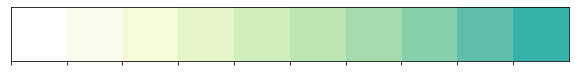

In [8]:
sns.palplot([cmap(i) for i in np.linspace(0, 1, 10)])

In [9]:
def path_effect_stroke(**kwargs):
    return [path_effects.Stroke(**kwargs), path_effects.Normal()]


pe = path_effect_stroke(linewidth=2.5, foreground="k")

In [10]:
team_rating_cols = ["SPI", "OFF", "DEF"]
group_stage_cols = ["1st Place", "2nd Place", "3rd Place"]
knockout_stage_cols = list(df.columns[-5:])


col_defs = (
    [
        ColumnDefinition(
            name="Flag",
            title="",
            textprops={"ha": "center"},
            width=0.5,
            plot_fn=circled_image,
        ),
        ColumnDefinition(
            name="Team",
            textprops={"ha": "left", "weight": "bold"},
            width=1.5,
        ),
        ColumnDefinition(
            name="Group",
            textprops={"ha": "center"},
            width=0.75,
        ),
        ColumnDefinition(
            name="SPI",
            group="Team Rating",
            textprops={"ha": "center"},
            width=0.75,
        ),
        ColumnDefinition(
            name="OFF",
            width=0.75,
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.35},
            },
            cmap=normed_cmap(df["OFF"], cmap=matplotlib.cm.PiYG, num_stds=2.5),
            group="Team Rating",
        ),
        ColumnDefinition(
            name="DEF",
            width=0.75,
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.35},
            },
            cmap=normed_cmap(df["DEF"], cmap=matplotlib.cm.PiYG_r, num_stds=2.5),
            group="Team Rating",
        ),
    ]
    + [
        ColumnDefinition(
            name=group_stage_cols[0],
            title=group_stage_cols[0].replace(" ", "\n", 1),
            formatter=decimal_to_percent,
            group="Group Stage Chances",
            border="left",
        )
    ]
    + [
        ColumnDefinition(
            name=col,
            title=col.replace(" ", "\n", 1),
            formatter=decimal_to_percent,
            group="Group Stage Chances",
        )
        for col in group_stage_cols[1:]
    ]
    + [
        ColumnDefinition(
            name=knockout_stage_cols[0],
            title=knockout_stage_cols[0].replace(" ", "\n", 1),
            formatter=decimal_to_percent,
            cmap=cmap,
            group="Knockout Stage Chances",
            border="left",
        )
    ]
    + [
        ColumnDefinition(
            name=col,
            title=col.replace(" ", "\n", 1),
            formatter=decimal_to_percent,
            cmap=cmap,
            group="Knockout Stage Chances",
        )
        for col in knockout_stage_cols[1:]
    ]
)

In [11]:
plt.rcParams["font.family"] = ["DejaVu Sans"]
plt.rcParams["savefig.bbox"] = "tight"

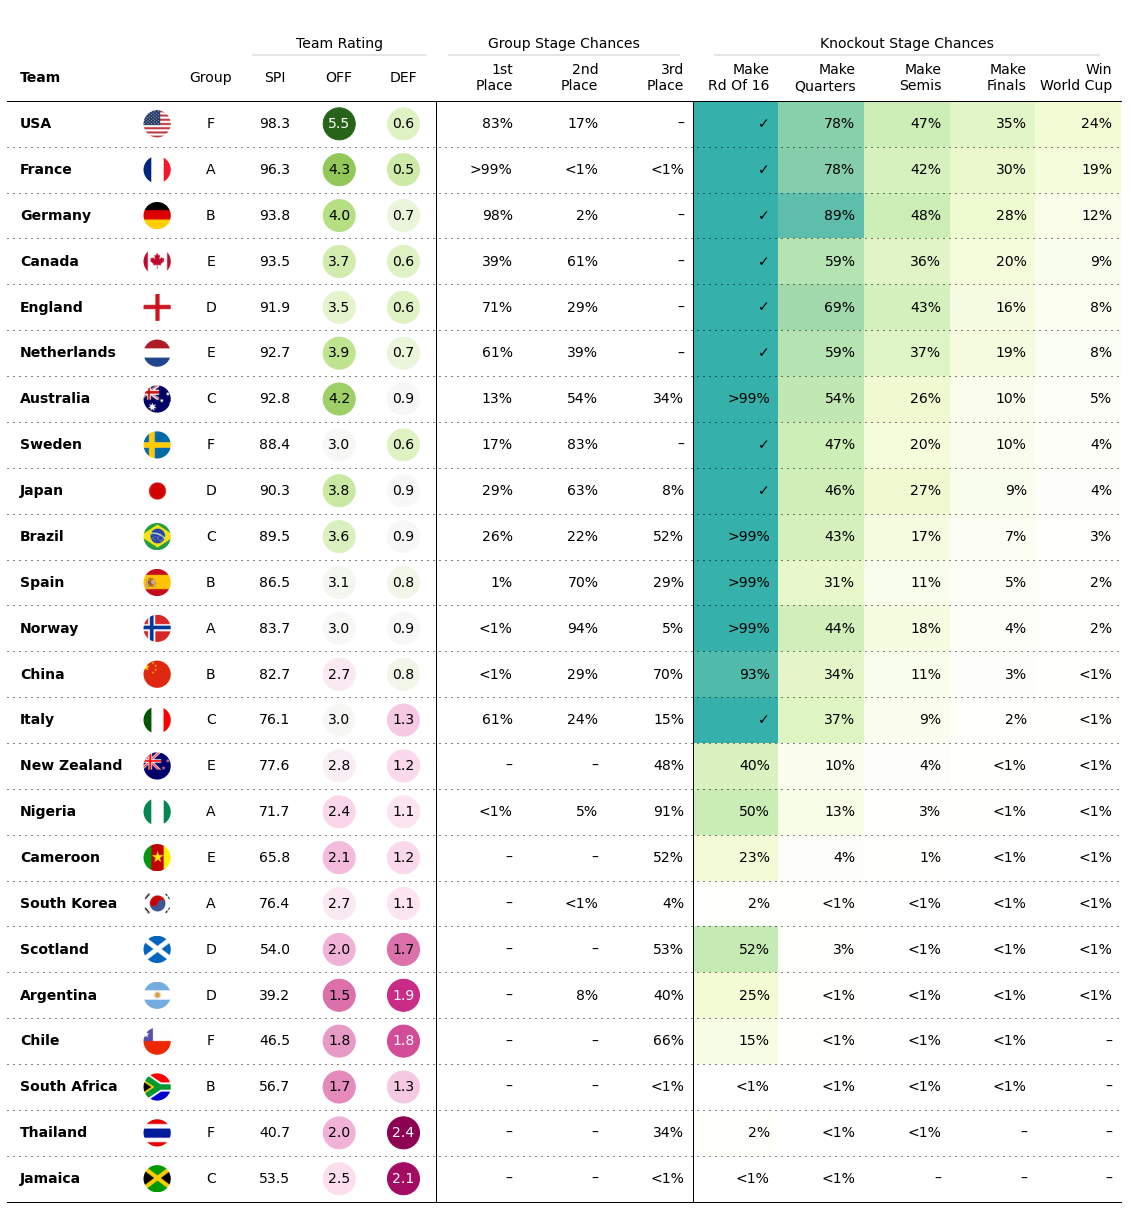

In [12]:
fig, ax = plt.subplots(figsize=(20, 22))

table = Table(
    df,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 14},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
).autoset_fontcolors(colnames=["OFF", "DEF"])

# fig.savefig("images/wwc_table.png", facecolor=ax.get_facecolor(), dpi=200)

In [13]:
# header_plot_fn for header images (or if "title" is a path to an image -> make it a subplot cell?)
# create RowDefinition class to adjust height etc?